<a href="https://colab.research.google.com/github/edayavuz/bullet3/blob/master/MachineLearning_EdanurYavuz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Veri setini yükle
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
column_names = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
data = pd.read_csv(url, names=column_names)

# Eksik değerleri doldur
data[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']] = data[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']].replace(0, np.nan)
data.fillna(data.mean(), inplace=True)

# Özellikler ve hedef değişkeni ayır
X = data.drop('Outcome', axis=1)
y = data['Outcome']

# Veriyi eğitim ve test setlerine ayır
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Veriyi standardize et
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [ ]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 9.2 MB/s eta 0:00:00


In [ ]:
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Optuna ile optimizasyon
def objective(trial):
    classifier_name = trial.suggest_categorical("classifier", ["SVC", "RandomForest", "LogisticRegression"])

    if classifier_name == "SVC":
        svc_c = trial.suggest_float("svc_c", 1e-6, 1e1, log=True)
        classifier_obj = SVC(C=svc_c, gamma="auto")

    elif classifier_name == "RandomForest":
        rf_n_estimators = trial.suggest_int("rf_n_estimators", 10, 100)
        rf_max_depth = trial.suggest_int("rf_max_depth", 2, 32)
        classifier_obj = RandomForestClassifier(n_estimators=rf_n_estimators, max_depth=rf_max_depth)

    else:
        lr_c = trial.suggest_float("lr_c", 1e-6, 1e1, log=True)
        classifier_obj = LogisticRegression(C=lr_c, max_iter=1000)

    score = cross_val_score(classifier_obj, X_train, y_train, n_jobs=-1, cv=3)
    accuracy = score.mean()
    return accuracy

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


[I 2024-06-11 13:37:33,057] A new study created in memory with name: no-name-c69debd9-bf16-45b3-89ec-dc112499ca5d
[I 2024-06-11 13:37:36,882] Trial 0 finished with value: 0.6530926191614858 and parameters: {'classifier': 'SVC', 'svc_c': 0.003282863733665799}. Best is trial 0 with value: 0.6530926191614858.
[I 2024-06-11 13:37:37,016] Trial 1 finished with value: 0.7133588394707476 and parameters: {'classifier': 'SVC', 'svc_c': 0.0991101161331364}. Best is trial 1 with value: 0.7133588394707476.
[I 2024-06-11 13:37:37,074] Trial 2 finished with value: 0.7263669695520485 and parameters: {'classifier': 'LogisticRegression', 'lr_c': 0.005715395754405789}. Best is trial 2 with value: 0.7263669695520485.
[I 2024-06-11 13:37:37,124] Trial 3 finished with value: 0.6530926191614858 and parameters: {'classifier': 'LogisticRegression', 'lr_c': 1.8744295625800155e-05}. Best is trial 2 with value: 0.7263669695520485.
[I 2024-06-11 13:37:37,403] Trial 4 finished with value: 0.755706998246453 and par

Number of finished trials:  100
Best trial:
  Value:  0.7801052128168341
  Params: 
    classifier: RandomForest
    rf_n_estimators: 83
    rf_max_depth: 18


In [ ]:
# En iyi modeli eğit
if trial.params['classifier'] == 'SVC':
    model = SVC(C=trial.params['svc_c'], gamma='auto')
elif trial.params['classifier'] == 'RandomForest':
    model = RandomForestClassifier(n_estimators=trial.params['rf_n_estimators'], max_depth=trial.params['rf_max_depth'])
else:
    model = LogisticRegression(C=trial.params['lr_c'], max_iter=1000)

model.fit(X_train, y_train)

# Modeli test setinde değerlendir
y_pred = model.predict(X_test)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


Accuracy: 0.7532467532467533
Precision: 0.6440677966101694
Recall: 0.6909090909090909
F1 Score: 0.6666666666666665


In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, roc_curve, confusion_matrix, auc, mean_squared_error)
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
!pip install optuna
import optuna
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, roc_curve, confusion_matrix, auc, mean_squared_error)
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
# Veri setini yükle
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
column_names = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
data = pd.read_csv(url, names=column_names)

# Özellikler ve hedef değişkeni ayırma
X = data.drop('Outcome', axis=1)
y = data['Outcome']

# Veri setini %70 eğitim ve %30 test olarak ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# NAIVE BAYES

In [ ]:
# Gaussian Naive Bayes sınıflandırıcısı oluşturma
gnb = GaussianNB()

# Modeli eğitim veri seti ile eğitme
gnb.fit(X_train, y_train)

# Eğitim ve test verileri üzerinde tahminler
y_train_pred = gnb.predict(X_train)
y_test_pred = gnb.predict(X_test)


Performans Metrikleri:
Accuracy: 0.7445887445887446
Precision: 0.7192989524576954
Recall: 0.7252897350993377
F1 Score: 0.7218855218855218
Mean Squared Error: 0.2554112554112554

Confusion Matrix:
[[119  32]
 [ 27  53]]


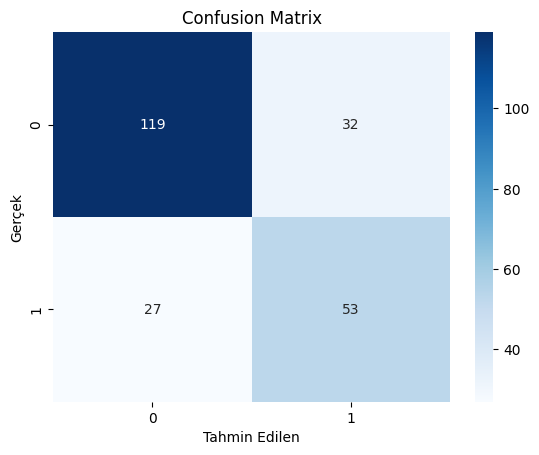

In [ ]:
# Performans metriklerini hesaplama
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, average='macro')
recall = recall_score(y_test, y_test_pred, average='macro')
f1 = f1_score(y_test, y_test_pred, average='macro')
mse = mean_squared_error(y_test, y_test_pred)

print("Performans Metrikleri:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Mean Squared Error: {mse}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Confusion Matrix'i görselleştirme
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.title('Confusion Matrix')
plt.show()


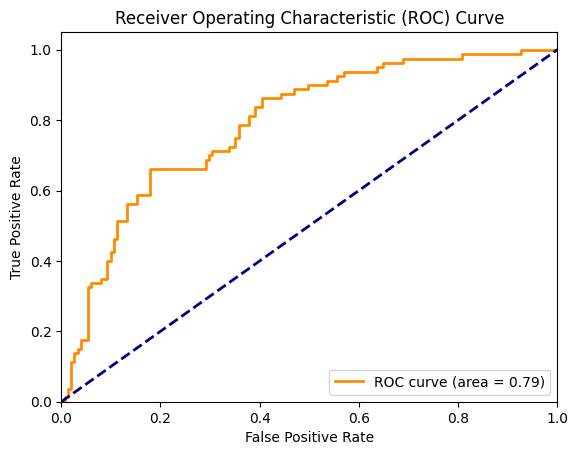

In [ ]:
# ROC Eğrisi ve AUC hesaplama
y_test_proba = gnb.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_test_proba[:, 1])
roc_auc = auc(fpr, tpr)

# ROC Eğrisini çizme
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


Performans Metrikleri:
Accuracy: 0.7445887445887446
Precision: 0.7192989524576954
Recall: 0.7252897350993377
F1 Score: 0.7218855218855218
Mean Squared Error: 0.2554112554112554

Confusion Matrix:
[[119  32]
 [ 27  53]]


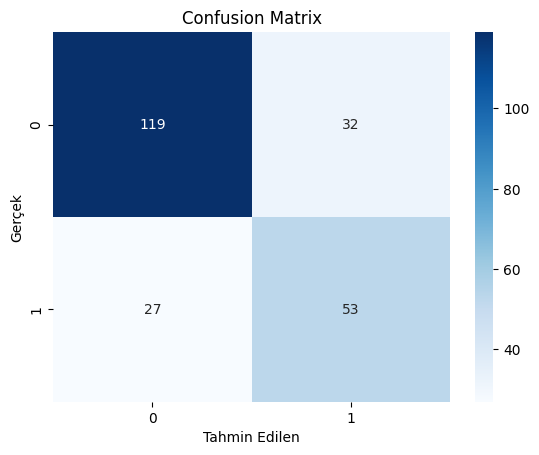

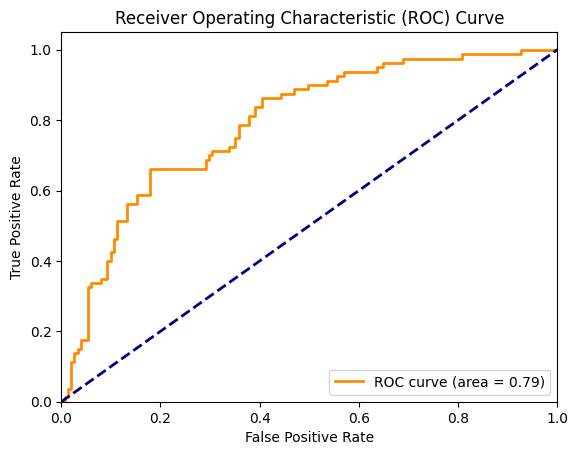

Sensitivity: 0.6625
Specificity: 0.7880794701986755


In [ ]:
!pip install optuna
import optuna
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, roc_curve, confusion_matrix, auc, mean_squared_error)
import matplotlib.pyplot as plt
import seaborn as sns

# Veri setini yükle
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
column_names = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
data = pd.read_csv(url, names=column_names)

# Özellikler ve hedef değişkeni ayırma
X = data.drop('Outcome', axis=1)
y = data['Outcome']

# Veri setini %70 eğitim ve %30 test olarak ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Gaussian Naive Bayes sınıflandırıcısı oluşturma
gnb = GaussianNB()

# Modeli eğitim veri seti ile eğitme
gnb.fit(X_train, y_train)

# Eğitim ve test verileri üzerinde tahminler
y_train_pred = gnb.predict(X_train)
y_test_pred = gnb.predict(X_test)

# Performans metriklerini hesaplama
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, average='macro')
recall = recall_score(y_test, y_test_pred, average='macro')
f1 = f1_score(y_test, y_test_pred, average='macro')
mse = mean_squared_error(y_test, y_test_pred)

print("Performans Metrikleri:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Mean Squared Error: {mse}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Confusion Matrix'i görselleştirme
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.title('Confusion Matrix')
plt.show()

# ROC Eğrisi ve AUC hesaplama
y_test_proba = gnb.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_test_proba[:, 1])
roc_auc = auc(fpr, tpr)

# ROC Eğrisini çizme
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Sensitivity ve Specificity hesaplama
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()

sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")


#  K-en

In [ ]:
import optuna
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error


In [ ]:
# Veri setini yükle
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
column_names = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
data = pd.read_csv(url, names=column_names)

# Özellikler ve hedef değişkeni ayırma
X = data.drop('Outcome', axis=1)
y = data['Outcome']

# Veri setini %70 eğitim ve %30 test olarak ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [ ]:
def objective(trial):
    k = trial.suggest_int('k', 1, 20)
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    return mean_squared_error(y_test, knn.predict(X_test))

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

best_k = study.best_params['k']
print(f"En iyi k değeri: {best_k}")


[I 2024-06-11 14:15:35,607] A new study created in memory with name: no-name-4e1886ac-b7d7-416c-854e-7425ba117df7
[I 2024-06-11 14:15:35,688] Trial 0 finished with value: 0.2857142857142857 and parameters: {'k': 18}. Best is trial 0 with value: 0.2857142857142857.
[I 2024-06-11 14:15:35,722] Trial 1 finished with value: 0.2813852813852814 and parameters: {'k': 10}. Best is trial 1 with value: 0.2813852813852814.
[I 2024-06-11 14:15:35,759] Trial 2 finished with value: 0.2727272727272727 and parameters: {'k': 17}. Best is trial 2 with value: 0.2727272727272727.
[I 2024-06-11 14:15:35,804] Trial 3 finished with value: 0.26406926406926406 and parameters: {'k': 16}. Best is trial 3 with value: 0.26406926406926406.
[I 2024-06-11 14:15:35,841] Trial 4 finished with value: 0.2987012987012987 and parameters: {'k': 6}. Best is trial 3 with value: 0.26406926406926406.
[I 2024-06-11 14:15:35,873] Trial 5 finished with value: 0.2683982683982684 and parameters: {'k': 11}. Best is trial 3 with value

En iyi k değeri: 13


In [ ]:
def objective(trial):
    k = trial.suggest_int('k', 1, 20)
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    return mean_squared_error(y_test, knn.predict(X_test))

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

best_k = study.best_params['k']
print(f"En iyi k değeri: {best_k}")


[I 2024-06-11 14:15:41,450] A new study created in memory with name: no-name-68cfbf59-e543-4e5e-bf2e-979dd3e742fa
[I 2024-06-11 14:15:41,484] Trial 0 finished with value: 0.2857142857142857 and parameters: {'k': 18}. Best is trial 0 with value: 0.2857142857142857.
[I 2024-06-11 14:15:41,518] Trial 1 finished with value: 0.27705627705627706 and parameters: {'k': 19}. Best is trial 1 with value: 0.27705627705627706.
[I 2024-06-11 14:15:41,552] Trial 2 finished with value: 0.2857142857142857 and parameters: {'k': 18}. Best is trial 1 with value: 0.27705627705627706.
[I 2024-06-11 14:15:41,589] Trial 3 finished with value: 0.29004329004329005 and parameters: {'k': 20}. Best is trial 1 with value: 0.27705627705627706.
[I 2024-06-11 14:15:41,623] Trial 4 finished with value: 0.26406926406926406 and parameters: {'k': 16}. Best is trial 4 with value: 0.26406926406926406.
[I 2024-06-11 14:15:41,657] Trial 5 finished with value: 0.2597402597402597 and parameters: {'k': 15}. Best is trial 5 with 

En iyi k değeri: 13


In [ ]:
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)

# Test verisi üzerinde tahminler
y_test_pred = knn.predict(X_test)

# Ortalama karesel hata hesaplama
mse = mean_squared_error(y_test, y_test_pred)
print(f"Ortalama karesel hata: {mse}")


Ortalama karesel hata: 0.2554112554112554


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Veri setini yükle
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
column_names = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
data = pd.read_csv(url, names=column_names)

# Özellikler ve hedef değişkeni ayırma
X = data.drop('Outcome', axis=1)
y = data['Outcome']

# Veri setini %70 eğitim ve %30 test olarak ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Veri setini yükle
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
column_names = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
data = pd.read_csv(url, names=column_names)

# Özellikler ve hedef değişkeni ayırma
X = data.drop('Outcome', axis=1)
y = data['Outcome']

# Veri setini %70 eğitim ve %30 test olarak ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error, classification_report

# K-en yakın komşuluk sınıflandırıcısını uygulama
k_values = [1, 3, 5, 7, 9]
best_k = None
best_score = 0

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    score = knn.score(X_test, y_test)
    if score > best_score:
        best_score = score
        best_k = k

# En iyi k değerini bulma
print(f"En iyi k değeri: {best_k}")

# Test verisi için ortalama karesel hata hesaplama
y_pred = knn.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Test verisi için ortalama karesel hata: {mse}")

# Performans metriklerini hesaplama
print("Performans Metrikleri:")
print(classification_report(y_test, y_pred))


En iyi k değeri: 9
Test verisi için ortalama karesel hata: 0.2987012987012987
Performans Metrikleri:
              precision    recall  f1-score   support

           0       0.78      0.76      0.77       151
           1       0.57      0.59      0.58        80

    accuracy                           0.70       231
   macro avg       0.67      0.67      0.67       231
weighted avg       0.70      0.70      0.70       231



# MLP - SVM

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

# Veri setini yükle
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
column_names = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
data = pd.read_csv(url, names=column_names)

# Bağımsız ve bağımlı değişkenleri ayır
X = data.drop('Outcome', axis=1)
y = data['Outcome']

# Veriyi eğitim ve test setlerine ayır
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Veriyi ölçeklendir
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# MLP sınıflandırıcıyı uygula
mlp = MLPClassifier(hidden_layer_sizes=(10, 10, 10), max_iter=1000)
mlp.fit(X_train, y_train)
mlp_predictions = mlp.predict(X_test)

# SVM sınıflandırıcıyı uygula
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)
svm_predictions = svm.predict(X_test)

# Sonuçları raporla
print("MLP Sınıflandırıcı Raporu:")
print(classification_report(y_test, mlp_predictions))
print("MLP Sınıflandırıcı Karışıklık Matrisi:")
print(confusion_matrix(y_test, mlp_predictions))

print("\nSVM Sınıflandırıcı Raporu:")
print(classification_report(y_test, svm_predictions))
print("SVM Sınıflandırıcı Karışıklık Matrisi:")
print(confusion_matrix(y_test, svm_predictions))


MLP Sınıflandırıcı Raporu:
              precision    recall  f1-score   support

           0       0.78      0.82      0.80       157
           1       0.56      0.50      0.53        74

    accuracy                           0.71       231
   macro avg       0.67      0.66      0.66       231
weighted avg       0.71      0.71      0.71       231

MLP Sınıflandırıcı Karışıklık Matrisi:
[[128  29]
 [ 37  37]]

SVM Sınıflandırıcı Raporu:
              precision    recall  f1-score   support

           0       0.81      0.90      0.85       157
           1       0.71      0.54      0.62        74

    accuracy                           0.78       231
   macro avg       0.76      0.72      0.73       231
weighted avg       0.78      0.78      0.77       231

SVM Sınıflandırıcı Karışıklık Matrisi:
[[141  16]
 [ 34  40]]


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
